<a href="https://colab.research.google.com/github/park1NG/MLTeamProject/blob/main/Aero_Delay_classification_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# 그래프에서 한글 폰트 출력하기 위한 라인
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 이후 런타임 끊고 재할당 필수 !

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [ ]:
def data_preprocessing(df):
    df.dropna()
    
    df = df.drop(df[df['예상'] == ':'].index)
    df = df.drop(df[df['도착'] == ':'].index)

    df['연월일'] = df['연월일'].astype(str)
    df['년'] = df['연월일'].str[:4].astype(int)
    df['월'] = df['연월일'].str[5:7].astype(int)
    df['일'] = df['연월일'].str[8:10].astype(int)

    df['예상'] = df['예상'].astype(str)
    df['예상_1'] = df['예상'].str[:2].astype(int)
    df['예상_2'] = df['예상'].str[3:].astype(int)

    df['도착'] = df['도착'].astype(str)
    df['도착_1'] = df['도착'].str[:2].astype(int)
    df['도착_2'] = df['도착'].str[3:].astype(int)

    df = df[['년', '월', '일', '항공사', '편명', '출발지', '예상_1', '예상_2', '도착_1', '도착_2', '현황']]
    # for col in list(set(df.columns) - set(categorical)):
    #     df = df.astypes({col:'float64'})
    
    categorical = ['항공사', '편명', '출발지', '현황']
    label_encoder = LabelEncoder()
    for col in categorical:
        df[col] = label_encoder.fit_transform(df[col])
        df = df.astype({col:'int'})

    df.info()

    return df


In [ ]:
def calculate_f1_score(y_true, y_pred):
    # 정밀도, 재현율, F1 점수 계산
    # micro, macro, samples, weighted
    # weighted는 클래스의 빈도수에 따라 중요도를 부여하기 때문에, 샘플 수가 적은 클래스에 더 큰 가중치를 부여
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    
    return f1

## 0번째 데이터 (file name: train_airportal.csv, test_airportal.csv) 

## 년, 월, 일, 항공사, 편명, 출발지, 예상_1, 예상_2, 도착_1, 도착_2, 현황

In [ ]:
data_train = pd.read_csv('./train_airportal.csv')
print(data_train['현황'].value_counts())
data_train = data_preprocessing(data_train)

data_test = pd.read_csv('./test_airportal.csv')
data_test = data_preprocessing(data_test)


x_train_tmp = data_train.iloc[:, :10]  # 0번부터 7번 열까지를 X로 설정
y_train_tmp = data_train.iloc[:, 10]   # 8번 열을 y로 설정

x_test_tmp = data_test.iloc[:, :10]  # 0번부터 7번 열까지를 X로 설정
y_test_tmp = data_test.iloc[:, 10]   # 8번 열을 y로 설정

print(x_test_tmp.info())
print(y_test_tmp.info())

출발    444548
지연     44655
취소       634
회항       199
Name: 현황, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 487399 entries, 0 to 490035
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   년       487399 non-null  int64
 1   월       487399 non-null  int64
 2   일       487399 non-null  int64
 3   항공사     487399 non-null  int64
 4   편명      487399 non-null  int64
 5   출발지     487399 non-null  int64
 6   예상_1    487399 non-null  int64
 7   예상_2    487399 non-null  int64
 8   도착_1    487399 non-null  int64
 9   도착_2    487399 non-null  int64
 10  현황      487399 non-null  int64
dtypes: int64(11)
memory usage: 44.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 182019 entries, 0 to 184516
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   년       182019 non-null  int64
 1   월       182019 non-null  int64
 2   일       182019 non-null  int64
 3   항공사     18

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train_tmp, y_train_tmp)

y_pred = model.predict(x_test_tmp)
accuracy = accuracy_score(y_test_tmp, y_pred)

print("정확도:", accuracy)

정확도: 0.8218867261110104


In [ ]:
print(calculate_f1_score(y_test_tmp, y_pred))

0.8588758767310122


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(x_train_tmp, y_train_tmp)

y_pred = model.predict(x_test_tmp)
accuracy = accuracy_score(y_test_tmp, y_pred)

print("정확도:", accuracy)

정확도: 0.9342705981243716


In [ ]:
print(calculate_f1_score(y_test_tmp, y_pred))

0.9265630879197277


## 1번째 데이터 (file name: 승객+편수16_18.csv, 승객+편수19.csv) 

## 예상_승객, 운행_편수 추가

In [ ]:
first_train = pd.read_csv('승객+편수16_18.csv')
first_test = pd.read_csv('승객+편수19.csv')

first_train.info()
first_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487255 entries, 0 to 487254
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   년       487255 non-null  int64
 1   월       487255 non-null  int64
 2   일       487255 non-null  int64
 3   항공사     487255 non-null  int64
 4   편명      487255 non-null  int64
 5   출발지     487255 non-null  int64
 6   예상_1    487255 non-null  int64
 7   예상_2    487255 non-null  int64
 8   현황      487255 non-null  int64
 9   예상_승객   487255 non-null  int64
 10  운항편수    487255 non-null  int64
dtypes: int64(11)
memory usage: 40.9 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181586 entries, 0 to 181585
Data columns (total 11 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   년       181586 non-null  int64
 1   월       181586 non-null  int64
 2   일       181586 non-null  int64
 3   항공사     181586 non-null  int64
 4   편명      181586 non-null  int64
 5   출발지     18158

In [ ]:
tmp1, tmp2 = first_train.iloc[:, :8], first_train.iloc[:, 9:]
x_train = pd.concat([tmp1, tmp2], axis=1)
y_train = first_train.iloc[:, 8]

tmp1, tmp2 = first_test.iloc[:, :8], first_test.iloc[:, 9:]
x_test = pd.concat([tmp1, tmp2], axis=1)
y_test = first_test.iloc[:, 8]

x_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 487255 entries, 0 to 487254
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   년       487255 non-null  int64
 1   월       487255 non-null  int64
 2   일       487255 non-null  int64
 3   항공사     487255 non-null  int64
 4   편명      487255 non-null  int64
 5   출발지     487255 non-null  int64
 6   예상_1    487255 non-null  int64
 7   예상_2    487255 non-null  int64
 8   예상_승객   487255 non-null  int64
 9   운항편수    487255 non-null  int64
dtypes: int64(10)
memory usage: 37.2 MB
<class 'pandas.core.series.Series'>
RangeIndex: 487255 entries, 0 to 487254
Series name: 현황
Non-Null Count   Dtype
--------------   -----
487255 non-null  int64
dtypes: int64(1)
memory usage: 3.7 MB


In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

print("정확도:", accuracy)

정확도: 0.8947716233630346


In [ ]:
print(calculate_f1_score(y_test, y_pred))

0.8973532629422621


In [ ]:
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

print("정확도:", accuracy)

정확도: 0.9098829204894651


In [ ]:
print(calculate_f1_score(y_test, y_pred))

0.9054245584171872


## 2번째 데이터 (file name:승객+편수+날씨16_18, 승객+편수+날씨19) 

## 실제 출발 시간 drop 적용

## 가시거리, 온도, 풍속 추가

In [ ]:
second_train = pd.read_csv('승객+편수+날씨16_18.csv')
second_test = pd.read_csv('승객+편수+날씨19.csv')

second_train.info()
second_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485851 entries, 0 to 485850
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   년       485851 non-null  int64  
 1   월       485851 non-null  int64  
 2   일       485851 non-null  int64  
 3   항공사     485851 non-null  int64  
 4   편명      485851 non-null  int64  
 5   출발지     485851 non-null  int64  
 6   예상_1    485851 non-null  int64  
 7   예상_2    485851 non-null  int64  
 8   현황      485851 non-null  int64  
 9   예상_승객   485851 non-null  int64  
 10  운항편수    485851 non-null  int64  
 11  Count   485851 non-null  int64  
 12  가시거리    485851 non-null  float64
 13  온도      485851 non-null  float64
 14  풍속      485851 non-null  float64
dtypes: float64(3), int64(12)
memory usage: 55.6 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181112 entries, 0 to 181111
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0  

In [ ]:
tmp1, tmp2 = second_train.iloc[:, :8], second_train.iloc[:, 9:]
x_train = pd.concat([tmp1, tmp2], axis=1)
y_train = second_train.iloc[:, 8]

tmp1, tmp2 = second_test.iloc[:, :8], second_test.iloc[:, 9:]
x_test = pd.concat([tmp1, tmp2], axis=1)
y_test = second_test.iloc[:, 8]

x_train.info()
y_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485851 entries, 0 to 485850
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   년       485851 non-null  int64  
 1   월       485851 non-null  int64  
 2   일       485851 non-null  int64  
 3   항공사     485851 non-null  int64  
 4   편명      485851 non-null  int64  
 5   출발지     485851 non-null  int64  
 6   예상_1    485851 non-null  int64  
 7   예상_2    485851 non-null  int64  
 8   예상_승객   485851 non-null  int64  
 9   운항편수    485851 non-null  int64  
 10  Count   485851 non-null  int64  
 11  가시거리    485851 non-null  float64
 12  온도      485851 non-null  float64
 13  풍속      485851 non-null  float64
dtypes: float64(3), int64(11)
memory usage: 51.9 MB
<class 'pandas.core.series.Series'>
RangeIndex: 485851 entries, 0 to 485850
Series name: 현황
Non-Null Count   Dtype
--------------   -----
485851 non-null  int64
dtypes: int64(1)
memory usage: 3.7 MB


In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

print("정확도:", accuracy)

정확도: 0.9292813286805954


In [ ]:
print(calculate_f1_score(y_test, y_pred))

0.9090970572550255


In [ ]:
importances = model.feature_importances_
for i, importance in enumerate(importances):
    print(f"Feature {x_train.columns[i]}: {round(importance, 4)}")

Feature 년: 0.0192
Feature 월: 0.0318
Feature 일: 0.053
Feature 항공사: 0.0749
Feature 편명: 0.157
Feature 출발지: 0.1301
Feature 예상_1: 0.0699
Feature 예상_2: 0.1156
Feature 예상_승객: 0.0895
Feature 운항편수: 0.0669
Feature Count: 0.0125
Feature 가시거리: 0.044
Feature 온도: 0.0763
Feature 풍속: 0.0592


In [ ]:
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

print("정확도:", accuracy)

정확도: 0.8769159415168515


In [ ]:
print(calculate_f1_score(y_test, y_pred))

0.8860154688359566


In [ ]:
importances = model.feature_importances_
total = sum(importances)
for i, importance in enumerate(importances):
    print(f"Feature {x_train.columns[i]}: {round(importance/total, 4)}")

Feature 년: 0.045
Feature 월: 0.0453
Feature 일: 0.0347
Feature 항공사: 0.0873
Feature 편명: 0.161
Feature 출발지: 0.111
Feature 예상_1: 0.1867
Feature 예상_2: 0.1047
Feature 예상_승객: 0.0317
Feature 운항편수: 0.0577
Feature Count: 0.0
Feature 가시거리: 0.0413
Feature 온도: 0.0647
Feature 풍속: 0.029


In [ ]:
rf_classifier = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],  # 나무의 개수
    'max_depth': [5, 10, 15],  # 나무의 최대 깊이
    'min_samples_split': [5, 10],  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],  # 단말 노드의 최소 샘플 수
    'max_features': ['sqrt', 'log2']  # 분할을 위해 고려할 최대 특성 수
}

# 그리드 서치를 학습 데이터에 적용하고 최적의 하이퍼파라미터를 찾기
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print('Best parameters found by grid search:', grid_search.best_params_)

# 최적의 모델로 예측 및 정확도 측정
y_pred = grid_search.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy with best parameters:', accuracy)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


In [ ]:
print(calculate_f1_score(y_test, y_pred))

In [ ]:
importances = rf_classifier.feature_importances_
for i, importance in enumerate(importances):
    print(f"Feature {x_train.columns[i]}: {round(importance, 4)}")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-32-d8d7ad43847c>", line 1, in <cell line: 1>
    importances = rf_classifier.feature_importances_
  File "/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py", line 628, in feature_importances_
    check_is_fitted(self)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1390, in check_is_fitted
    raise NotFittedError(msg % {"name": type(estimator).__name__})
sklearn.exceptions.NotFittedError: This RandomForestClassifier instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceba

In [ ]:
lgb_classifier = lgb.LGBMClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [2, 5, 15],
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.01, 0.05],
    'min_child_samples': [100, 200, 250],
}

# 그리드 서치를 학습 데이터에 적용하고 최적의 하이퍼파라미터를 찾기
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print('Best parameters found by grid search:', grid_search.best_params_)

# 최적의 모델로 예측 및 정확도 측정
y_pred = grid_search.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy with best parameters:', accuracy)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found by grid search: {'learning_rate': 0.05, 'max_depth': 5, 'min_child_samples': 250, 'n_estimators': 100, 'num_leaves': 63}
Test accuracy with best parameters: 0.9409039710234551


In [ ]:
print(calculate_f1_score(y_test, y_pred))

0.9135754411908189


## 3번째 데이터 (file name:승객+편수+날씨+공휴일16_18, 승객+편수+날씨+공휴일19) 

## 실제 출발 시간 drop 적용

## 평일, 금요일, 주말, 공휴일 추가

In [ ]:
plt.rc('font', family='NanumBarunGothic') 

In [ ]:
third_train = pd.read_csv('holidays_with_weather16_18.csv')
third_test = pd.read_csv('holidays_with_weather19.csv')
third_train = third_train.drop(labels=['도착_1', '도착_2'], axis=1)
third_train = third_train.rename(columns = {'운항편수':'운행_편수', '출발지':'도착지', 'Count':'시간대'})
third_test = third_test.rename(columns = {'운항편수':'운행_편수', '출발지':'도착지', 'Count':'시간대'})


third_train.info()
third_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 485994 entries, 0 to 485993
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   년       485994 non-null  int64  
 1   월       485994 non-null  int64  
 2   일       485994 non-null  int64  
 3   항공사     485994 non-null  int64  
 4   편명      485994 non-null  int64  
 5   도착지     485994 non-null  int64  
 6   예상_1    485994 non-null  int64  
 7   예상_2    485994 non-null  int64  
 8   현황      485994 non-null  int64  
 9   예상_승객   485994 non-null  int64  
 10  운행_편수   485994 non-null  int64  
 11  시간대     485994 non-null  int64  
 12  가시거리    485994 non-null  float64
 13  온도      485994 non-null  float64
 14  풍속      485994 non-null  float64
 15  평일      485994 non-null  int64  
 16  금요일     485994 non-null  int64  
 17  주말      485994 non-null  int64  
 18  공휴일     485994 non-null  int64  
dtypes: float64(3), int64(16)
memory usage: 70.4 MB
<class 'pandas.core.frame.DataFrame'>
R

In [ ]:
tmp1, tmp2 = third_train.iloc[:, :8], third_train.iloc[:, 9:]
x_train = pd.concat([tmp1, tmp2], axis=1)
y_train = third_train.iloc[:, 8]

tmp1, tmp2 = third_test.iloc[:, :8], third_test.iloc[:, 9:]
x_test = pd.concat([tmp1, tmp2], axis=1)
y_test = third_test.iloc[:, 8]

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

print("정확도:", accuracy)

정확도: 0.922683201554839


In [ ]:
print(calculate_f1_score(y_test, y_pred))

0.9063804378491506


Feature 년: 0.0171
Feature 월: 0.0304
Feature 일: 0.0478
Feature 항공사: 0.0731
Feature 편명: 0.149
Feature 도착지: 0.1221
Feature 예상_1: 0.0854
Feature 예상_2: 0.1091
Feature 예상_승객: 0.0996
Feature 운행_편수: 0.0611
Feature 시간대: 0.0157
Feature 가시거리: 0.0405
Feature 온도: 0.0697
Feature 풍속: 0.0537
Feature 평일: 0.0083
Feature 금요일: 0.0065
Feature 주말: 0.0078
Feature 공휴일: 0.0029


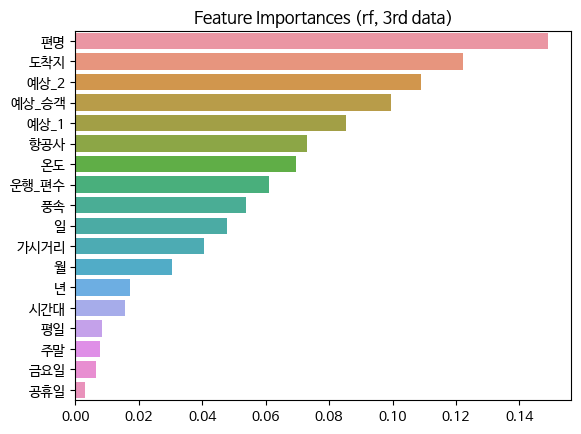

In [ ]:
importances = model.feature_importances_
total = sum(importances)
val = []
for i, importance in enumerate(importances):
    val.append([x_train.columns[i], round(importance/total, 4)])
    print(f"Feature {x_train.columns[i]}: {round(importance/total, 4)}")
val.sort(key=lambda x: -x[1])

x_val_rf, y_val_rf = [], []
for i, j in val:
    x_val_rf.append(i)
    y_val_rf.append(j)

plt.figure()
plt.title('Feature Importances (rf, 3rd data)')
sns.barplot(y=x_val_rf, x=y_val_rf)
plt.show()

In [ ]:
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

print("정확도:", accuracy)

정확도: 0.9224236936260436


In [ ]:
print(calculate_f1_score(y_test, y_pred))

0.9130551047267633


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Feature 년: 0.029
Feature 월: 0.0374
Feature 일: 0.0422
Feature 항공사: 0.0729
Feature 편명: 0.1338
Feature 도착지: 0.1064
Feature 예상_1: 0.1169
Feature 예상_2: 0.0858
Feature 예상_승객: 0.0869
Feature 운행_편수: 0.0842
Feature 시간대: 0.0208
Feature 가시거리: 0.0392
Feature 온도: 0.0791
Feature 풍속: 0.0536
Feature 평일: 0.0018
Feature 금요일: 0.0049
Feature 주말: 0.002
Feature 공휴일: 0.0031


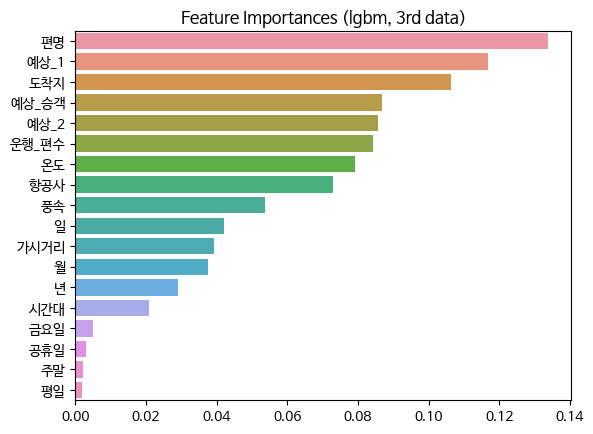

In [ ]:
importances = model.feature_importances_
total = sum(importances)
val = []
for i, importance in enumerate(importances):
    val.append([x_train.columns[i], round(importance/total, 4)])
    print(f"Feature {x_train.columns[i]}: {round(importance/total, 4)}")
val.sort(key=lambda x: -x[1])

x_val_lgbm, y_val_lgbm = [], []
for i, j in val:
    x_val_lgbm.append(i)
    y_val_lgbm.append(j)

plt.figure()
plt.title('Feature Importances (lgbm, 3rd data)')
sns.barplot(y=x_val_lgbm, x=y_val_lgbm)
plt.show()

In [ ]:
rf_classifier = RandomForestClassifier()
param_grid = {
    'n_estimators': [100, 200],  # 나무의 개수
    'max_depth': [5, 10, 15],  # 나무의 최대 깊이
    'min_samples_split': [5, 10],  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4],  # 단말 노드의 최소 샘플 수
    'max_features': ['sqrt', 'log2']  # 분할을 위해 고려할 최대 특성 수
}

# 그리드 서치를 학습 데이터에 적용하고 최적의 하이퍼파라미터를 찾기
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print('Best parameters found by grid search:', grid_search.best_params_)

# 최적의 모델로 예측 및 정확도 측정
y_pred = grid_search.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy with best parameters:', accuracy)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters found by grid search: {'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Test accuracy with best parameters: 0.9403573479393966


In [ ]:
print(calculate_f1_score(y_test, y_pred))

0.9114526690278847


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
model = RandomForestClassifier(max_depth=5, max_features='sqrt', min_samples_leaf=1, min_samples_split=5, n_estimators=100)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

print("정확도:", accuracy)

정확도: 0.9403573479393966


Feature 년: 0.0108
Feature 월: 0.1142
Feature 일: 0.011
Feature 항공사: 0.013
Feature 편명: 0.0306
Feature 도착지: 0.013
Feature 예상_1: 0.226
Feature 예상_2: 0.0108
Feature 예상_승객: 0.0299
Feature 운행_편수: 0.0897
Feature 시간대: 0.1717
Feature 가시거리: 0.112
Feature 온도: 0.1258
Feature 풍속: 0.0287
Feature 평일: 0.0052
Feature 금요일: 0.0028
Feature 주말: 0.0039
Feature 공휴일: 0.0008


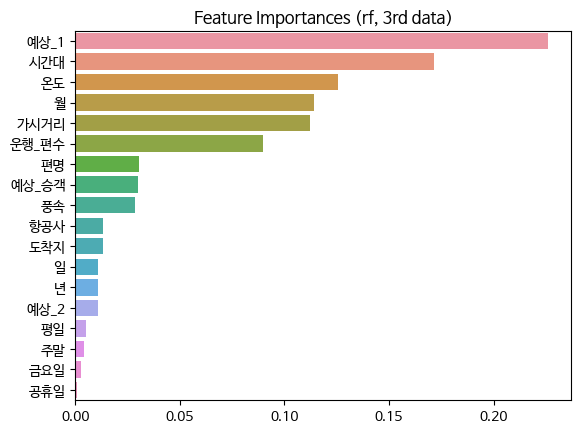

In [ ]:
importances = model.feature_importances_
total = sum(importances)
val = []
for i, importance in enumerate(importances):
    val.append([x_train.columns[i], round(importance/total, 4)])
    print(f"Feature {x_train.columns[i]}: {round(importance/total, 4)}")
val.sort(key=lambda x: -x[1])

x_val_rf, y_val_rf = [], []
for i, j in val:
    x_val_rf.append(i)
    y_val_rf.append(j)

plt.figure()
plt.title('Feature Importances (rf, 3rd data)')
sns.barplot(y=x_val_rf, x=y_val_rf)
plt.show()

In [ ]:
lgb_classifier = lgb.LGBMClassifier()
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [2, 5, 15],
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.01, 0.05],
    'min_child_samples': [100, 200, 250],
}

# 그리드 서치를 학습 데이터에 적용하고 최적의 하이퍼파라미터를 찾기
grid_search = GridSearchCV(estimator=lgb_classifier, param_grid=param_grid, cv=5, verbose=2, n_jobs=-1)
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 출력
print('Best parameters found by grid search:', grid_search.best_params_)

# 최적의 모델로 예측 및 정확도 측정
y_pred = grid_search.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
print('Test accuracy with best parameters:', accuracy)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters found by grid search: {'learning_rate': 0.05, 'max_depth': 2, 'min_child_samples': 250, 'n_estimators': 100, 'num_leaves': 31}
Test accuracy with best parameters: 0.9405064269623217


In [ ]:
print(calculate_f1_score(y_test, y_pred))

0.9119063576861237


In [ ]:
model = lgb.LGBMClassifier(learning_rate=0.05, max_depth=2, min_child_samples=250, n_estimators=100, num_leaves=31)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)

print("정확도:", accuracy)

정확도: 0.9405064269623217


Feature 년: 0.03
Feature 월: 0.0933
Feature 일: 0.0122
Feature 항공사: 0.0611
Feature 편명: 0.0878
Feature 도착지: 0.06
Feature 예상_1: 0.1178
Feature 예상_2: 0.0456
Feature 예상_승객: 0.0244
Feature 운행_편수: 0.0922
Feature 시간대: 0.0344
Feature 가시거리: 0.1378
Feature 온도: 0.1411
Feature 풍속: 0.0478
Feature 평일: 0.0044
Feature 금요일: 0.01
Feature 주말: 0.0
Feature 공휴일: 0.0


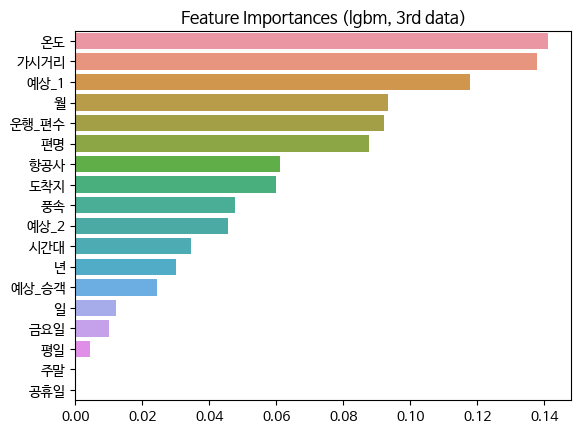

In [ ]:
importances = model.feature_importances_
total = sum(importances)
val = []
for i, importance in enumerate(importances):
    val.append([x_train.columns[i], round(importance/total, 4)])
    print(f"Feature {x_train.columns[i]}: {round(importance/total, 4)}")
val.sort(key=lambda x: -x[1])

x_val_lgbm, y_val_lgbm = [], []
for i, j in val:
    x_val_lgbm.append(i)
    y_val_lgbm.append(j)

plt.figure()
plt.title('Feature Importances (lgbm, 3rd data)')
sns.barplot(y=x_val_lgbm, x=y_val_lgbm)
plt.show()